In [9]:
import pickle
import os
from glob import glob
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from model import analyse, visualise
import numpy as np

# Experiment 1

Let's read in the files:

In [3]:
output_dir = "./experiments/experiment1/experiment1_output"
file_pattern = "experiment1_results_*.pickle"

results = []

for file_path in glob(os.path.join(output_dir, file_pattern)):

    with open(file_path, "rb") as f:
        run_results = pickle.load(f)
        results.append(run_results)

In [4]:
avg_duration = sum([res[1] for res in results], start=datetime.timedelta(0)) / len(results)
print(avg_duration)

16:20:08.286625


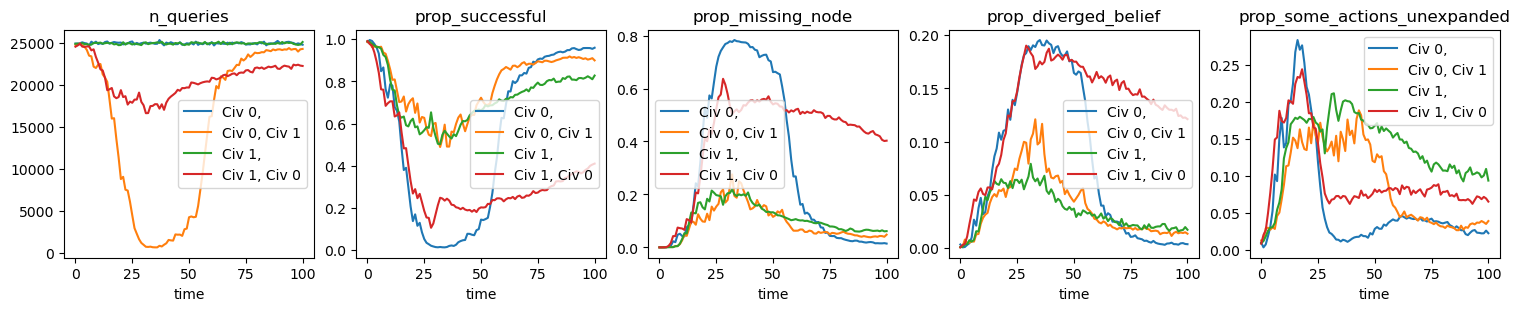

In [5]:
res = results[0]

# let's turn the results into a DataFrame
rows = []

for t, time_step_data in enumerate(res[-1]):
    for tree, values in time_step_data.items():
        # if there are no queries, skip
        if values[0] == 0:
            continue

        rows.append((t, tree, *values))

query_data = pd.DataFrame(
    rows,                       
    columns=(
        'time', 
        'tree', 
        'n_queries', 
        'prop_successful', 
        'prop_missing_node', 
        'prop_diverged_belief', 
        'prop_some_actions_unexpanded'
    )
)

# plot

fig, axs = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(15,3))

for i, column in enumerate(query_data.columns[2:]):

    for tree, tree_data in query_data.groupby('tree'):

        axs[i].plot('time', column, data=tree_data, label=tree)

    axs[i].set_title(column)
    axs[i].legend()
    axs[i].set_xlabel('time')
    

Let's visualise the query success rates as averages over all runs over time.

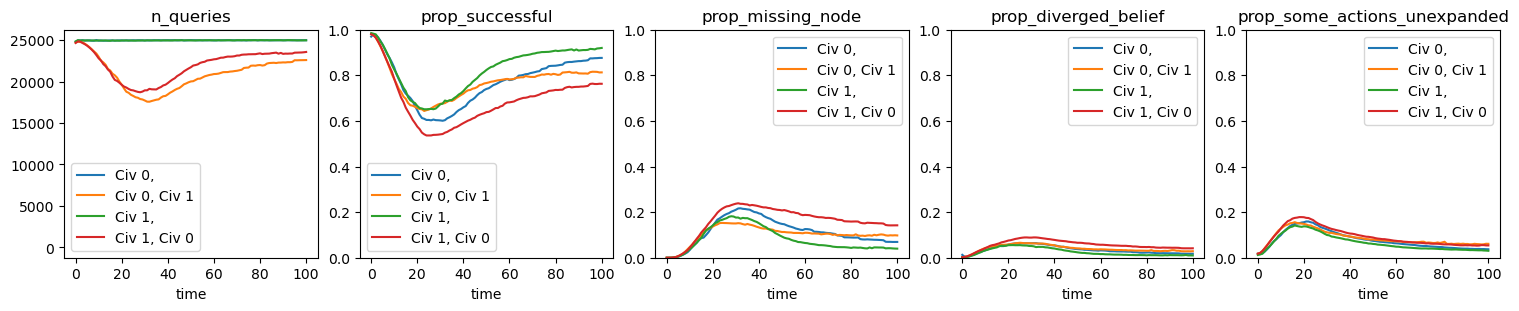

In [6]:
# let's turn the results into a DataFrame
rows = []

for run_result in results:
    for t, time_step_data in enumerate(run_result[-1]):
        for tree, values in time_step_data.items():
            # if there are no queries, skip
            if values[0] == 0:
                continue

            rows.append((t, tree, *values))

query_data = pd.DataFrame(
    rows,                       
    columns=(
        'time', 
        'tree', 
        'n_queries', 
        'prop_successful', 
        'prop_missing_node', 
        'prop_diverged_belief', 
        'prop_some_actions_unexpanded'
    )
)

# plot

fig, axs = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(15,3))

for i, metric in enumerate(query_data.columns[2:]):

    for tree, tree_data in query_data.groupby('tree'):

        avg_metric = tree_data.groupby("time")[metric].mean()

        axs[i].plot(avg_metric.index, avg_metric, label=tree)
        #axs[i].plot('time', column, data=tree_data, label=tree)

    axs[i].set_title(metric)
    axs[i].legend()
    axs[i].set_xlabel('time')

    if metric != "n_queries":
        axs[i].set_ylim((0,1))
    else:
        # add point 0 to data limits so scaling is correct
        axs[i].update_datalim([(0, 0)])
    

Let's calculate the average proportion of all actions that are attacks at each reward level:

In [8]:
results[0]

(98,
 datetime.timedelta(seconds=68213, microseconds=581133),
 7,
 -0.4,
 101,
               Technology  Radius of Influence  Visibility Factor  \
 Step AgentID                                                       
 0    0          0.998917         5.879000e+01           1.000000   
      1          0.000014         2.276405e-06           1.000000   
 1    0          0.998917         5.879000e+01           1.000000   
      1          0.000014         2.276405e-06           1.000000   
 2    0          0.999313         9.263930e+01           1.000000   
 ...                  ...                  ...                ...   
 98   1          1.000000         3.154717e+13           0.000015   
 99   0          1.000000         1.633124e+15           0.000004   
      1          1.000000         5.441913e+13           0.000015   
 100  0          1.000000         1.633124e+15           0.000004   
      1          1.000000         8.536390e+13           0.000015   
 
                      

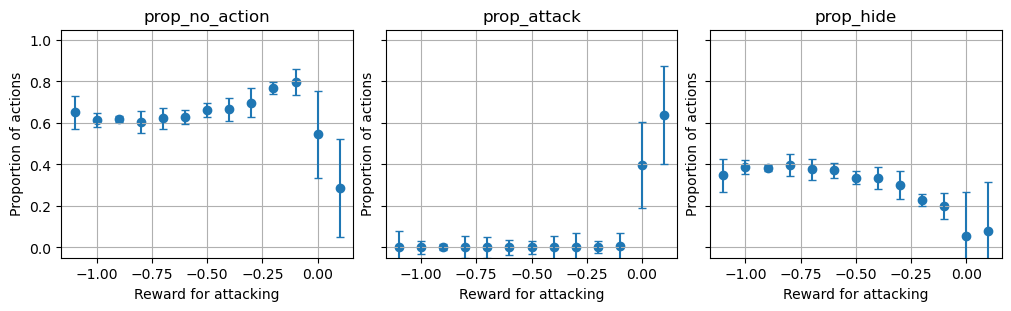

In [7]:
rows = []

for run_result in results:
    attack_reward = run_result[3]
    run_actions = run_result[6]

    prop_no_action = ((run_actions["action"] == 0) | ((run_actions["action"] == "a") & (run_actions["attack_successful"].isnull()))).mean()
    prop_attack = ((run_actions["action"] == "a") & (~run_actions["attack_successful"].isnull())).mean()
    prop_hide = ((run_actions["action"] == 1)).mean()
    rows.append((attack_reward, prop_no_action, prop_attack, prop_hide))

prop_action_data = pd.DataFrame(rows, columns=('attack_reward', 'prop_no_action', 'prop_attack', 'prop_hide'))

fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(10, 3), sharey=True)

for i, metric in enumerate(("prop_no_action", "prop_attack", "prop_hide")):
    prop_action_data_groups = prop_action_data.groupby("attack_reward")
    avg_metric = prop_action_data_groups.mean()[metric]
    avg_metric_error_margin = prop_action_data_groups.aggregate(lambda x: analyse.t_confidence_interval(x)[1]).iloc[:, 0]

    axs[i].scatter(x=avg_metric.index, y=avg_metric)
    axs[i].errorbar(x=avg_metric.index, y=avg_metric, yerr=avg_metric_error_margin, fmt="none", capsize=3)

    axs[i].set_xlabel("Reward for attacking")
    axs[i].set_ylabel("Proportion of actions")
    axs[i].set_title(metric)
    axs[i].grid()
    axs[i].set_ylim((-0.05, 1.05))

plt.show()

Let's then plot the average reward received by agents:

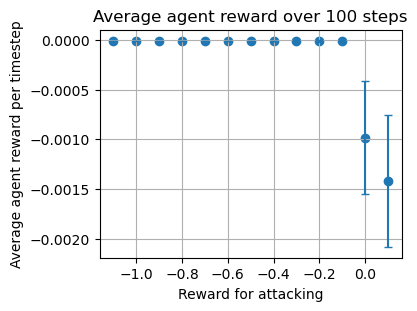

In [8]:
rows = []

for run_result in results:
    attack_reward = run_result[3]
    run_rewards = run_result[7]
    avg_run_reward = run_rewards['reward'].mean() / (2 * 101)
    rows.append((attack_reward, avg_run_reward))

avg_reward_data = pd.DataFrame(rows, columns=('attack_reward', 'avg_run_reward'))

fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 3))

avg_reward_data_groups = avg_reward_data.groupby("attack_reward")
avg_avg_reward = avg_reward_data_groups.mean()["avg_run_reward"]
avg_avg_reward_error_margin = avg_reward_data_groups.aggregate(lambda x: analyse.t_confidence_interval(x)[1]).iloc[:, 0]

ax.scatter(x=avg_avg_reward.index, y=avg_avg_reward)
ax.errorbar(x=avg_avg_reward.index, y=avg_avg_reward, yerr=avg_avg_reward_error_margin, fmt="none", capsize=3)

ax.set_xlabel("Reward for attacking")
ax.set_ylabel("Average agent reward per timestep")
ax.set_title("Average agent reward over 100 steps")
ax.grid()

plt.show()

This is a measure of the rationality of the system as a whole. The “rational” scenario for the system is when no one attacks or hides at all.

Next, let's investigate the length of attack streaks. We will only do this when the attack reward is either 0 or 0.1.

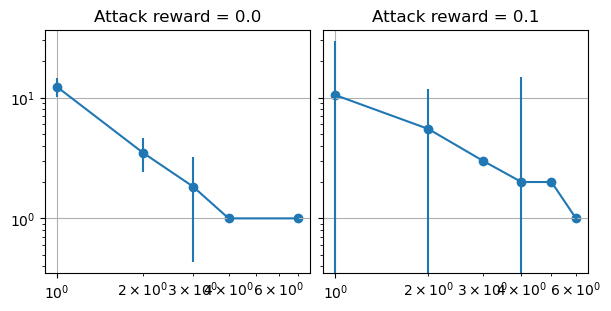

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), constrained_layout=True, sharey=True)

rows = []

for run_result in results:
    attack_reward = run_result[3]

    # don't analyse simulations with negative attack reward
    if attack_reward < 0:
        continue

    run_length = run_result[4]
    # exclude runs that were less than 80 time steps (an arbitrary number)
    if run_length < 80:
        continue

    run_action_data = run_result[6]

    run_streaks = analyse.count_attack_streaks(run_action_data)

    for streak_length, count in run_streaks.items():
        rows.append((attack_reward, streak_length, count))
    
attack_streak_data = pd.DataFrame(rows, columns=("attack_reward", "streak_length", "streak_count"))
    

for i, (attack_reward, attack_reward_attack_streak_data) in enumerate(attack_streak_data.groupby("attack_reward")):

    attack_streak_data_grouped = attack_reward_attack_streak_data.groupby("streak_length")
    avg_streak_length_count = attack_streak_data_grouped["streak_count"].mean()
    avg_streak_length_count_error_margin = attack_streak_data_grouped["streak_count"].aggregate(lambda x: analyse.t_confidence_interval(x)[1])

    axs[i].scatter(avg_streak_length_count.index, avg_streak_length_count)
    axs[i].errorbar(x=avg_streak_length_count.index, y=avg_streak_length_count, yerr=avg_streak_length_count_error_margin)

    axs[i].set_yscale("log")
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_title(f"Attack reward = {attack_reward}")

plt.show()

Let us then start to quantify error in predicting the other agents' actions. First, we will plot the prediction error (norm of the difference vector of action utility estimates) over time for different attack rewards.

In [ ]:
rows = []

for run_result in results:
    attack_reward = run_result[3]
    action_utility_estimates = run_result[8]

    for t, t_data in action_utility_estimates.groupby("time"):
        
        for estimator, actor in ((0,1), (1,0)):

            actor_estimate = t_data[(t_data["estimator"] == actor) & (t_data["actor"] == actor)]["qualities"].iloc[0]
            estimator_estimate = t_data[(t_data["estimator"] == estimator) & (t_data["actor"] == actor)]["qualities"].iloc[0]
            difference = np.linalg.norm(np.array(actor_estimate) - np.array(estimator_estimate))
            rows.append((attack_reward, t, difference))

action_utility_estimate_data = pd.DataFrame(rows, columns=("attack_reward", "time", "distance"))

In [16]:
action_utility_estimate_data

,attack_reward,time,distance
0,-0.4,0,0.609457
1,-0.4,0,0.148933
2,-0.4,1,0.136568
3,-0.4,1,0.321362
4,-0.4,2,0.030992
...,...,...,...
23935,-0.6,98,0.767415
23936,-0.6,99,1.013733
23937,-0.6,99,0.385502
23938,-0.6,100,0.248635


time
0      0.748757
1      0.618193
2      0.426387
3      0.395025
4      0.392875
         ...   
96     0.571675
97     0.522167
98     0.517724
99     0.536159
100    0.496618
Name: distance, Length: 101, dtype: float64


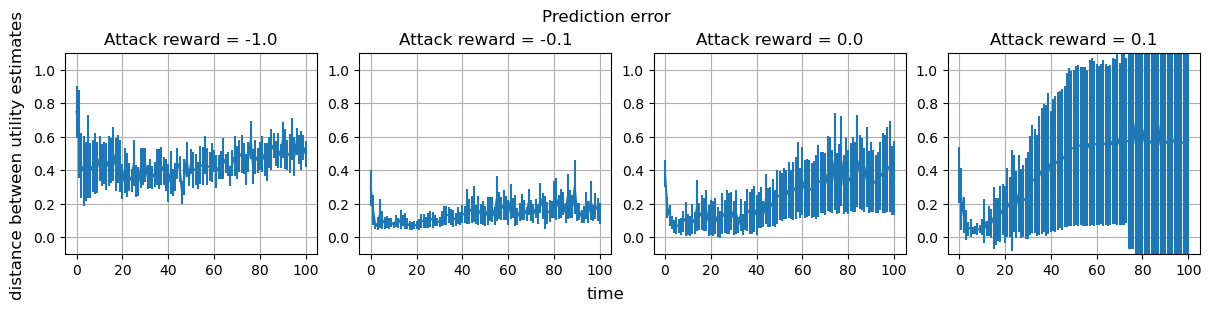

In [37]:
fig, axs = plt.subplots(constrained_layout=True, nrows=1, ncols=4, figsize=(12, 3))

action_utility_estimate_data_subs = action_utility_estimate_data[action_utility_estimate_data["attack_reward"].isin((-1.0, -0.1, 0, 0.1))]

for i, (attack_reward, attack_reward_data) in enumerate(action_utility_estimate_data_subs.groupby("attack_reward")):

    avg_action_utility_estimate = attack_reward_data.groupby("time")["distance"].mean()
    avg_action_utility_estimate_error_margin = attack_reward_data.groupby("time")["distance"].aggregate(lambda x: analyse.t_confidence_interval(x)[1])

    if avg_action_utility_estimate.max() > 0.7:
        print(avg_action_utility_estimate)

    #lines = ax.plot(avg_action_utility_estimate.index, avg_action_utility_estimate, label=attack_reward)
    axs[i].errorbar(x=avg_action_utility_estimate.index, y=avg_action_utility_estimate, yerr=avg_action_utility_estimate_error_margin, label=attack_reward)
    axs[i].set_title(f"Attack reward = {attack_reward}")
    axs[i].grid()
    axs[i].set_ylim((-0.1, 1.1))

fig.supxlabel("time")
fig.supylabel("distance between utility estimates")
fig.suptitle("Prediction error")
plt.show()